## Thyroid aspiration classification notebook



### install libraries and packages

In [1]:
import fastai
from fastai.text.all import *
import sklearn
from sklearn import metrics
import os
import seaborn as sns

from fastai.callback.wandb import *

import matplotlib.pyplot as plt

from collections import Counter

import wandb
!wandb login

wandb: Currently logged in as: jaskol (use `wandb login --relogin` to force relogin)


In [2]:
os.environ['WANDB_SILENT'] = 'true'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'working on {device}, GPU is a {torch.cuda.get_device_name()}')
print(f'using pytorch version {torch.__version__}')
print(f'using fast.ai version {fastai.__version__}')

working on cuda, GPU is a Quadro RTX 5000
using pytorch version 1.7.0+cu101
using fast.ai version 2.2.5


### import data

In [4]:
model_path = 'C:\\Users\\jasko\\Desktop\\machine_learning\\my_projects\\thyroid_aspiration\models'
results_path = 'C:\\Users\\jasko\\Desktop\\machine_learning\\my_projects\\thyroid_aspiration\\results'
data_path = 'C:\\Users\\jasko\\Desktop\\machine_learning\\my_projects\\thyroid_aspiration'

In [5]:
data= pd.read_csv(data_path + '/thyroid_data.csv')

In [6]:
data.head()

,Hospital,PT Class,Procedure End Time,Procedure Sign-off Time,Modality,Procedure #,Procedure Name,Mode Grouping,Accession,MRN,Patient Account #,Health Card +Version,DOB,Age at Procedure Date,P FEE,T Fee,Sign off Rad,Exam Result,labels
0,BCH,Outpatient,03/02/2020 9:48,03/02/2020 10:36,US,7893.0,ASPIRATION - THYROID,US,15995314.0,N000895092,0NX075968/19,1655789590-AT,06/11/1967,53.0,60.55,94.6,FITZGERALD,"FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request for thyroid nodule biopsy.\r\n\r\nCOMPARISON: None available. There is an outside report.\r\n\r\n\r\nPROCEDURE:\r\n\r\nThe material risks (including hemorrhage and infection) of the procedure were explained to the patient, and informed consent was obtained.\r\n\r\nFollowing sterile prep, drape, and local anesthesia, a 25 gauge 1.5"" needle was advanced into complex nodule in the right lobe under direct sonographic guidance. Adequate samples were obtained.\r\n\r\nThe samples were placed in appropriate fluid and sent for analysis. The patient tole...",1
1,BCH,Outpatient,03/02/2020 10:41,03/02/2020 12:08,US,7893.0,ASPIRATION - THYROID,US,15995463.0,N000885031,0NX075992/19,2064714070-AW,10/02/1997,23.0,60.55,94.6,FITZGERALD,"FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request for thyroid nodule biopsy.\r\n\r\nCOMPARISON: None available.\r\n\r\nPROCEDURE:\r\n\r\nThe material risks (including hemorrhage and infection) of the procedure were explained to the patient, and informed consent was obtained.\r\n\r\nFollowing sterile prep, drape, and local anesthesia, a 25 gauge 1.5"" needle was advanced into nodule, predominantly isoechoic to hyperechoic and solid under direct sonographic guidance. Adequate samples were obtained.\r\n\r\nThe samples were placed in appropriate fluid and sent for analysis. The patient tolerated th...",1
2,BCH,Outpatient,03/02/2020 10:36,03/02/2020 12:06,US,7893.0,ASPIRATION - THYROID,US,15995472.0,N000691085,0NX075987/19,8316472276-HW,22/05/1953,67.0,60.55,94.6,FITZGERALD,"FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request for thyroid nodule biopsy.\r\n\r\nCOMPARISON: None available.\r\n\r\nPROCEDURE:\r\n\r\nThe material risks (including hemorrhage and infection) of the procedure were explained to the patient, and informed consent was obtained.\r\n\r\nFollowing sterile prep, drape, and local anesthesia, a 25 gauge 1.5"" needle was advanced into 2 nodules in the right lobe under direct sonographic guidance. Adequate samples were obtained.\r\n\r\nThe samples were placed in appropriate fluid and sent for analysis. The patient tolerated the procedure well, with no imm...",2
3,BCH,Outpatient,03/02/2020 11:19,03/02/2020 12:07,US,7893.0,ASPIRATION - THYROID,US,15995493.0,N000021506,0NX075991/19,NaN,26/02/1952,68.0,60.55,94.6,FITZGERALD,"FNA BIOPSY OF THYROID\r\n\r\nHISTORY: Request for thyroid nodule biopsy.\r\n\r\nCOMPARISON: None available.\r\n\r\nPROCEDURE:\r\n\r\nThe material risks (including hemorrhage and infection) of the procedure were explained to the patient, and informed consent was obtained.\r\n\r\nFollowing sterile prep, drape, and local anesthesia, a 25 gauge 1.5"" needle was advanced into nodule at the medial right lobe extending into the right side of the isthmus under direct sonographic guidance. Adequate samples were obtained.\r\n\r\nThe samples were placed in appropriate fluid and sent for analysis. The ...",1
4,BCH,Outpatient,04/02/2020 10:26,04/02/2020 10:39,US,7893.0,ASPIRATION - THYROID,US,15998039.0,N000386598,0NX076298/19,3188415867-XN,22/05/1950,70.0,60.55,94.6,SEGAL,".\r\n\r\nFNA BIOPSY OF THYROID\r\n\r\nHISTORY: Dominant left thyroid nodule (interpolar nodule) biopsy.\r\n\r\nCOMPARISON: 7/1/2020\r\n\r\nPROCEDURE:\r\n\r\nThe material risks (including hemorrhage and infection) of the procedure were explained to the patient, and informed consent was obtained.\r\n\r\nFollowing sterile prep and local anesthesia, a 25 gauge 1.5"" needle was advanced into the lesion under direct sonographic guidance. Three samples were obtained.\r\n\r\nThe samples were placed in a

In [7]:
data.columns

Index(['Hospital', 'PT Class', 'Procedure End Time',
       'Procedure Sign-off  Time', 'Modality', 'Procedure #', 'Procedure Name',
       'Mode Grouping', 'Accession', 'MRN', 'Patient Account #',
       'Health Card +Version', 'DOB', 'Age at Procedure Date', 'P FEE',
       'T Fee', 'Sign off Rad', 'Exam Result', 'labels'],
      dtype='object')

In [8]:
data.shape

(654, 19)

In [9]:
data = data.dropna(subset = ['labels'])
data.shape

(652, 19)

In [10]:
data['target'] = data['labels'].map({'1':'1', '2':'>=1', '>2':'>=1'})

In [11]:
Counter(data.target)

Counter({'1': 533, '>=1': 119})

In [12]:
ltd_data = data[['Exam Result', 'target']]

In [13]:
ltd_data.to_csv('thyroid_ltd.csv', index = False)

In [14]:
#this represents the lengths of the reports, to use for when I want to start tuning hyperparams
lens = [len(x.split()) for x in ltd_data['Exam Result']]
pd.Series(lens).describe()

count    652.000000
mean      97.196319
std       50.872070
min        5.000000
25%       66.750000
50%       89.000000
75%      114.000000
max      610.000000
dtype: float64

In [15]:
data['lengths'] = lens

In [16]:
short_reports = data[data['lengths'] <= 30]; short_reports.shape

(2, 21)

In [17]:
for rep in short_reports['Exam Result']:  print(f'\n{rep}\n--------------------------')


Combined report. See accession 16262799
--------------------------

Procedure:

Thyroid gland aspiration

TECHNIQUE: Sterile technique with local anesthetic 1% Xylocaine.

3, uncomplicated 27-gauge FNA capillary biopsies from the isthmic.

Summary:

Uncomplicated isthmic nodule FNA biopsy.
--------------------------


In [18]:
long_reports = data[data['lengths'] >= 200]; long_reports.shape

(16, 21)

In [19]:
for rep in long_reports['Exam Result']:  print(f'\n{rep}\n--------------------------')


******** ADDENDUM #1 ********
ADDENDUM: Cytology results from FNA biopsy of left thyroid nodule at lower pole demonstrate features in keeping with a benign follicular nodule. The cytology results are concordant with imaging findings.

Cytology results from FNA biopsy of calcified left thyroid nodule at upper pole demonstrate atypia of undetermined significance. The aspirate is hypocellular, limiting interpretation. The specimen contains a rare clusters of cells with Hurthle change and a background of inflammatory cells. There are clusters of epithelial cells show nuclear enlargement and overlap. The significance of this finding is unclear. There are no definite features of papillary thyroid carcinoma. The cytology results are concordant with imaging findings. Sonographic follow-up recommended.

Cytology results from FNA biopsy of right thyroid nodule at interpolar to lower pole region demonstrate features in keeping with a benign follicular nodule with background features suggestive l

In [20]:
#loads result dataframe or initializes an empty one
try:
    results_df = pd.read_csv('results lung rads.csv')
except:
    results_df = pd.DataFrame(columns = ['experiment description', 'num samples', 'weighting', 'f1w', 'acc', 'auroc', 'ppv', 'sens', 'batch size'])

results_df.index = list(range(len(results_df)))   #to clean the index 
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,thyroid baseline,652,NaN,0.905804,0.907692,0.814766,0.666667,0.736842,64
1,thyroid baseline,652,NaN,0.842980,0.838462,0.892273,0.550000,0.478261,64
2,thyroid baseline,652,NaN,0.801190,0.807692,0.783636,0.300000,0.352941,64
3,thyroid baseline,652,NaN,0.835404,0.838462,0.834000,0.600000,0.666667,64
4,thyroid baseline,652,NaN,0.785400,0.792308,0.836333,0.466667,0.560000,64
5,thyroid baseline,652,NaN,0.810601,0.815385,0.839333,0.533333,0.615385,64


In [21]:
#defining a replacement for the after batch method of the WandbCallback

def JJ_wand_after_batch(self):
        "Log hyper-parameters and training loss"
        if self.training:
            self._wandb_step += 1
            self._wandb_epoch += 1/self.n_iter
            hypers = {f'{k}_{i}':v for i,h in enumerate(learn.opt.hypers) for k,v in h.items() if ('wd' in k) or  ('lr' in k)}
            wandb.log({'epoch': self._wandb_epoch, 'train_loss': to_detach(self.smooth_loss.clone()), 'raw_loss': to_detach(self.loss.clone()), **hypers}, step=self._wandb_step)

#and mokeypatching it (overwriting the original method in the callback)
WandbCallback.after_batch = JJ_wand_after_batch

In [22]:
def get_metrics(preds,predictions, true_vals, update_results = True, print_confusion = True):
    ''' Note that in this version discharge is the positive results
     and admit is the negative result'''

    f1_w = sklearn.metrics.f1_score(true_vals, preds, average='weighted')
    f1 = sklearn.metrics.f1_score(true_vals, preds, average=None)
    acc = sklearn.metrics.accuracy_score(true_vals, preds)
    prec = sklearn.metrics.precision_score(true_vals,preds, average=None) 
    rec = sklearn.metrics.recall_score(true_vals,preds, average=None)
    auroc = sklearn.metrics.roc_auc_score(true_vals,predictions[:,1])
    confusion = sklearn.metrics.confusion_matrix(true_vals, preds)

    tn, fn, fp, tp = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]

    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)

    print ('Metrics Report:')
    print ('---------------')
    print ('weighted f1: ', f1_w)
    print ('AUROC:       ',auroc)
    print ('accuracy:    ', acc)
    print ('precision:   ', prec)
    print ('recall:      ', rec)
    print ('sensitivity: ', sens)
    print ('specificity: ', spec)
    print ('PPV:         ', ppv)
    print ('NPV:         ', npv)
    print ()
    
    if print_confusion:
        sns.heatmap(confusion,
            annot = True,fmt = '',
            cmap = 'Blues',
            cbar = False,
            xticklabels = ['N', 'Y'],
            yticklabels = ['N', 'Y'] )
        plt.xlabel('actual')
        plt.ylabel('predicted')
        plt.title('needs f/u predictions confusion matrix')
        plt.show()

    if update_results == True:
        results_df.loc[len(results_df)] = [desc,num_samples, weights, f1_w, acc, auroc, ppv, sens, batch_size]

In [23]:
def get_metrics_multi(preds,predictions, true_vals, update_results = True, print_confusion = True):
    
    f1_w = sklearn.metrics.f1_score(true_vals, predictions, average='weighted')
    #f1 = sklearn.metrics.f1_score(true_vals, preds, average=None)
    acc = sklearn.metrics.accuracy_score(true_vals, predictions)
    prec = sklearn.metrics.precision_score(true_vals,predictions, average='weighted') 
    rec = sklearn.metrics.recall_score(true_vals,predictions, average='weighted')
    confusion = sklearn.metrics.confusion_matrix(true_vals, predictions)
    try: auroc = sklearn.metrics.roc_auc_score(true_vals,preds, multi_class = 'ovo')
    except: auroc = 'can not calculate auroc'
    

    print ('Metrics Report:')
    print ('---------------')
    print ('weighted f1: ', f1_w)
    print ('AUROC:       ',auroc)
    print ('accuracy:    ', acc)
    print ('precision:   ', prec)
    print ('recall:      ', rec)
    
    accuracy_per_class(preds, true_vals)
    #print ()
    #print ('Accuracy per Class:')
    #print ('-------------------')
    #for item in res: print (item[0], ',',item[1])
    
    if print_confusion:
        sns.heatmap(confusion,
            annot = True,fmt = '',
            cmap = 'Blues',
            cbar = False)
        plt.xlabel('actual')
        plt.ylabel('predicted')
        plt.title('Lung rads predictions confusion matrix')
        plt.show()

    if update_results == True:
        results_df.loc[len(results_df)] = [desc,num_samples, weights, f1_w, acc, auroc, prec, rec, batch_size]


In [24]:
def accuracy_per_class(preds, labels, df = data, label_col = 'labels'):
    label_dict = {k:v for v,k in enumerate(set(df[label_col]))}
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

### fine tune language model

#### forward

In [32]:
dls_lm = TextDataLoaders.from_df(ltd_data, is_lm=True, valid_pct=0.1, text_col='Exam Result')

C:\Users\jasko\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [34]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [37]:
learn_lm.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.724839,2.843937,0.471108,17.183277,00:04
1,3.438990,1.970884,0.585272,7.177018,00:02
2,2.846195,1.861352,0.605585,6.432427,00:02


In [39]:
learn_lm.freeze_to(-2)
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.975892,1.524828,0.665885,4.594351,00:02
1,1.768089,1.350588,0.707060,3.859694,00:02
2,1.629842,1.334871,0.715133,3.799505,00:02


In [40]:
learn_lm.freeze_to(-1)
learn_lm.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.511631,1.308353,0.719358,3.700076,00:02
1,1.472933,1.286321,0.724551,3.619447,00:02
2,1.461018,1.281555,0.724913,3.602235,00:02


In [41]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.385662,1.210646,0.740061,3.355652,00:02
1,1.297979,1.086303,0.764062,2.963300,00:02
2,1.202784,0.999729,0.776837,2.717546,00:03
3,1.112064,0.933797,0.797164,2.544151,00:03
4,1.026577,0.887003,0.805599,2.427843,00:02
5,0.963332,0.865786,0.809418,2.376874,00:02
6,0.903355,0.849121,0.814583,2.337590,00:02
7,0.860180,0.834316,0.816464,2.303239,00:02
8,0.819132,0.830691,0.819199,2.294905,00:02
9,0.793396,0.830182,0.819488,2.293736,00:03


In [42]:
with open(model_path + '/lm_vocab.pkl', 'wb') as f:
    pickle.dump(dls_lm.vocab, f)

In [44]:
learn_lm.save_encoder(model_path + '/finetuned_enc_fwd')

#### backward

In [45]:
dls_lm_bwd = TextDataLoaders.from_df(data, is_lm=True, valid_pct=0.1, text_col='Exam Result', is_backward = True)

C:\Users\jasko\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [46]:
learn_lm_bwd = language_model_learner(dls_lm_bwd, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [47]:
learn_lm_bwd.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.757165,2.948041,0.449436,19.068562,00:02
1,3.453910,2.134635,0.558222,8.453960,00:02
2,2.863207,2.029434,0.579830,7.609778,00:02


In [48]:
learn_lm_bwd.freeze_to(-2)
learn_lm_bwd.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.952327,1.723822,0.620587,5.605916,00:02
1,1.756870,1.548864,0.657418,4.706123,00:02
2,1.627508,1.518475,0.667721,4.565259,00:02


In [49]:
learn_lm_bwd.freeze_to(-1)
learn_lm_bwd.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.454280,1.489481,0.672216,4.434795,00:02
1,1.445624,1.464414,0.676794,4.325006,00:02
2,1.452327,1.460723,0.676939,4.309076,00:02


In [50]:
learn_lm_bwd.unfreeze()
learn_lm_bwd.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.373740,1.408829,0.689102,4.091160,00:02
1,1.303088,1.295375,0.715660,3.652366,00:03
2,1.211794,1.149530,0.737661,3.156708,00:03
3,1.106664,1.088218,0.752956,2.968978,00:03
4,1.027493,1.033776,0.761367,2.811662,00:03
5,0.958950,1.007416,0.767837,2.738515,00:03
6,0.896431,0.988339,0.776155,2.686768,00:03
7,0.852590,0.979716,0.777509,2.663700,00:03
8,0.824081,0.982464,0.781281,2.671030,00:03
9,0.790955,0.982490,0.781808,2.671100,00:03


In [52]:
learn_lm_bwd.save_encoder(model_path + '/finetuned_enc_bwd')

### first pass at classification

- lung rads classes - new baseline

#### forward

In [25]:
desc = 'thyroid baseline'
num_samples = len(data)
weights = None
batch_size = 64    #fast.ai default

In [26]:
with open(model_path + '/lm_vocab.pkl', 'rb') as f:
    lm_vocab = pickle.load(f)

In [27]:
dls_cls = TextDataLoaders.from_df(ltd_data, text_col = 'Exam Result', label_col = 'target', seed = 42, text_vocab = lm_vocab, num_workers = 0)

C:\Users\jasko\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [76]:
wandb.init(project='thyroid asp', name = 'baseline');

In [77]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=accuracy, cbs=[WandbCallback(), SaveModelCallback(fname = 'thyroid')]).to_fp16()

In [78]:
learn.load_encoder(model_path + '/finetuned_enc_fwd');

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.14454397559165955)

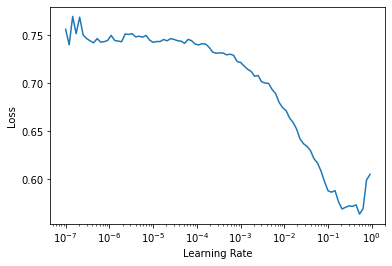

In [79]:
learn.lr_find()

In [80]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.735494,0.703933,0.523077,00:01
1,0.653137,0.548239,0.776923,00:01
2,0.591443,0.570084,0.815385,00:01


Better model found at epoch 0 with valid_loss value: 0.7039328217506409.
Better model found at epoch 1 with valid_loss value: 0.5482387542724609.


In [81]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.504840,0.563672,0.746154,00:01
1,0.482525,0.549951,0.792308,00:01
2,0.433926,0.576698,0.669231,00:01


Better model found at epoch 0 with valid_loss value: 0.5636721253395081.
Better model found at epoch 1 with valid_loss value: 0.549950897693634.


In [82]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.332696,0.811587,0.630769,00:02
1,0.334162,0.538020,0.715385,00:02
2,0.288639,0.539831,0.715385,00:02


Better model found at epoch 0 with valid_loss value: 0.8115865588188171.
Better model found at epoch 1 with valid_loss value: 0.5380204916000366.


In [83]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.225286,0.504662,0.715385,00:02
1,0.210732,0.503390,0.730769,00:02
2,0.192585,0.563584,0.738462,00:02
3,0.177575,0.538526,0.746154,00:02
4,0.169562,0.533817,0.746154,00:02


Better model found at epoch 0 with valid_loss value: 0.5046619176864624.
Better model found at epoch 1 with valid_loss value: 0.503390371799469.


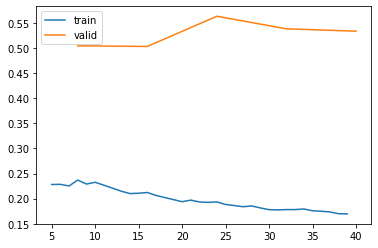

In [84]:
learn.recorder.plot_loss()

In [85]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

Metrics Report:
---------------
weighted f1:  0.7419846258908404
AUROC:        0.8069999999999999
accuracy:     0.7307692307692307
precision:    [0.85714286 0.43589744]
recall:       [0.78       0.56666667]
sensitivity:  0.4358974358974359
specificity:  0.8571428571428571
PPV:          0.5666666666666667
NPV:          0.78



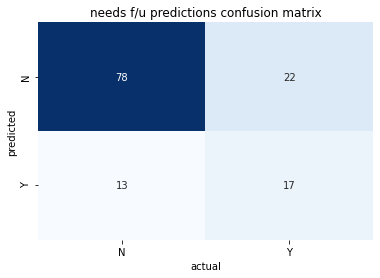

In [86]:
get_metrics(predictions, preds, targets)

In [87]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,thyroid baseline,652,NaN,0.905804,0.907692,0.814766,0.666667,0.736842,64
1,thyroid baseline,652,NaN,0.842980,0.838462,0.892273,0.550000,0.478261,64
2,thyroid baseline,652,NaN,0.801190,0.807692,0.783636,0.300000,0.352941,64
3,thyroid baseline,652,None,0.835404,0.838462,0.834000,0.600000,0.666667,64
4,thyroid baseline,652,None,0.785400,0.792308,0.836333,0.466667,0.560000,64
5,thyroid baseline,652,None,0.810601,0.815385,0.839333,0.533333,0.615385,64
6,thyroid baseline,652,None,0.741985,0.730769,0.807000,0.566667,0.435897,64


In [88]:
learn.export(model_path + '/thyroid_baseline_fwd.pkl')

In [89]:
wandb.finish()

### second pass at classification

- needs f/u

In [90]:
desc = 'label smoothing'
num_samples = len(data)
weights = None
batch_size = 64    #fast.ai default

In [91]:
wandb.init(project='thyroid asp', name = 'labell smoothing');

In [92]:
loss_func = LabelSmoothingCrossEntropyFlat()

In [93]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, loss_func = loss_func, drop_mult=0.5, metrics=accuracy, cbs=[WandbCallback(), SaveModelCallback(fname = 'thyroid_smooth')]).to_fp16()

In [94]:
learn.load_encoder(model_path + '/finetuned_enc_fwd');

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.05754399299621582)

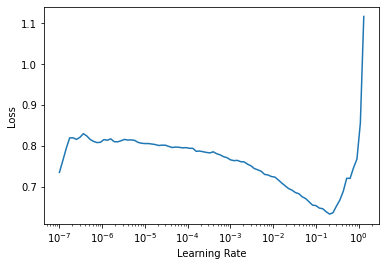

In [95]:
learn.lr_find()

In [96]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.818974,0.632288,0.738462,00:01
1,0.687729,0.600667,0.676923,00:01
2,0.614784,0.604874,0.661538,00:01


Better model found at epoch 0 with valid_loss value: 0.6322882771492004.
Better model found at epoch 1 with valid_loss value: 0.600666880607605.


In [97]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.525870,0.675621,0.746154,00:01
1,0.528852,0.671466,0.669231,00:01
2,0.489752,0.653098,0.753846,00:01


Better model found at epoch 0 with valid_loss value: 0.6756214499473572.
Better model found at epoch 1 with valid_loss value: 0.6714655160903931.
Better model found at epoch 2 with valid_loss value: 0.6530976295471191.


In [98]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.433333,0.611109,0.730769,00:02
1,0.388387,0.589398,0.746154,00:02
2,0.354524,0.533625,0.723077,00:02


Better model found at epoch 0 with valid_loss value: 0.61110919713974.
Better model found at epoch 1 with valid_loss value: 0.5893978476524353.
Better model found at epoch 2 with valid_loss value: 0.5336247086524963.


In [99]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.293002,0.558371,0.738462,00:02
1,0.292386,0.628329,0.730769,00:02
2,0.287407,0.526884,0.761538,00:02
3,0.284064,0.540231,0.761538,00:02
4,0.279774,0.537703,0.776923,00:02


Better model found at epoch 0 with valid_loss value: 0.5583705902099609.
Better model found at epoch 2 with valid_loss value: 0.5268840193748474.


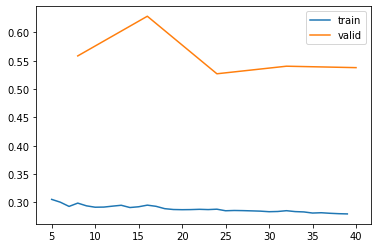

In [100]:
learn.recorder.plot_loss()

In [101]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

Metrics Report:
---------------
weighted f1:  0.7714720972176013
AUROC:        0.8501666666666666
accuracy:     0.7615384615384615
precision:    [0.87912088 0.48717949]
recall:       [0.8        0.63333333]
sensitivity:  0.48717948717948717
specificity:  0.8791208791208791
PPV:          0.6333333333333333
NPV:          0.8



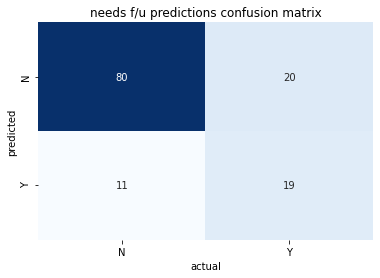

In [102]:
get_metrics(predictions, preds, targets)

In [103]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,thyroid baseline,652,NaN,0.905804,0.907692,0.814766,0.666667,0.736842,64
1,thyroid baseline,652,NaN,0.842980,0.838462,0.892273,0.550000,0.478261,64
2,thyroid baseline,652,NaN,0.801190,0.807692,0.783636,0.300000,0.352941,64
3,thyroid baseline,652,None,0.835404,0.838462,0.834000,0.600000,0.666667,64
4,thyroid baseline,652,None,0.785400,0.792308,0.836333,0.466667,0.560000,64
5,thyroid baseline,652,None,0.810601,0.815385,0.839333,0.533333,0.615385,64
6,thyroid baseline,652,None,0.741985,0.730769,0.807000,0.566667,0.435897,64
7,label smoothing,652,None,0.771472,0.761538,0.850167,0.633333,0.487179,64


In [104]:
wandb.finish()

### add weights

In [28]:
Counter(data.target)

Counter({'1': 533, '>=1': 119})

In [29]:
for num in Counter(data.target).values():  print (num/len(data))

0.8174846625766872
0.18251533742331288


In [30]:
desc = 'label smoothing'
num_samples = len(data)
weights = 0.7,0.3
batch_size = 64    #fast.ai default

In [31]:
weight = torch.tensor([weights], dtype = torch.float32).cuda()

In [32]:
wandb.init(project='thyroid asp', name = 'labell smoothing weighted 3');

In [33]:
loss_func = LabelSmoothingCrossEntropyFlat(weight = weight)

In [34]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, loss_func = loss_func, drop_mult=0.5, metrics=accuracy, cbs=[WandbCallback(), SaveModelCallback(fname = 'thyroid_smooth')]).to_fp16()

In [35]:
learn.load_encoder(model_path + '/finetuned_enc_fwd');

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.12022644281387329)

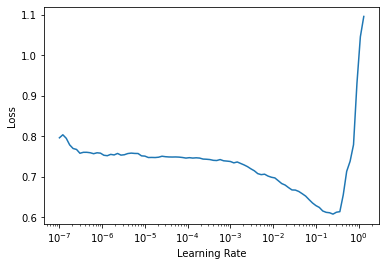

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(3, 1e-2)

WandbCallback could not log config parameters -> can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


epoch,train_loss,valid_loss,accuracy,time
0,0.755168,0.520246,0.753846,00:01
1,0.673825,0.552745,0.738462,00:01
2,0.617121,0.561238,0.746154,00:01


Better model found at epoch 0 with valid_loss value: 0.5202462673187256.


In [38]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

WandbCallback could not log config parameters -> can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


epoch,train_loss,valid_loss,accuracy,time
0,0.630739,0.465379,0.761538,00:01
1,0.575275,0.496284,0.753846,00:01
2,0.522249,0.471101,0.784615,00:01


Better model found at epoch 0 with valid_loss value: 0.46537908911705017.


In [39]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

WandbCallback could not log config parameters -> can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


epoch,train_loss,valid_loss,accuracy,time
0,0.528086,0.544566,0.761538,00:01
1,0.504603,0.464162,0.823077,00:01
2,0.460508,0.453084,0.815385,00:01


Better model found at epoch 0 with valid_loss value: 0.5445661544799805.
Better model found at epoch 1 with valid_loss value: 0.46416184306144714.
Better model found at epoch 2 with valid_loss value: 0.4530836343765259.


In [40]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

WandbCallback could not log config parameters -> can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


epoch,train_loss,valid_loss,accuracy,time
0,0.365776,0.449522,0.830769,00:01
1,0.358031,0.438172,0.823077,00:01
2,0.345183,0.460608,0.823077,00:01
3,0.336463,0.472558,0.815385,00:01
4,0.329993,0.489044,0.815385,00:01


Better model found at epoch 0 with valid_loss value: 0.44952189922332764.
Better model found at epoch 1 with valid_loss value: 0.4381718635559082.


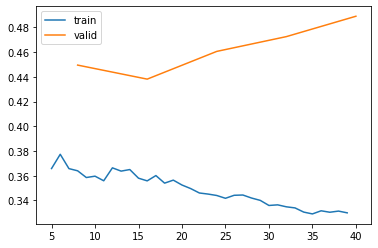

In [41]:
learn.recorder.plot_loss()

In [42]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

Metrics Report:
---------------
weighted f1:  0.8112754118946068
AUROC:        0.7853333333333333
accuracy:     0.823076923076923
precision:    [0.85321101 0.66666667]
recall:       [0.93       0.46666667]
sensitivity:  0.6666666666666666
specificity:  0.8532110091743119
PPV:          0.4666666666666667
NPV:          0.93



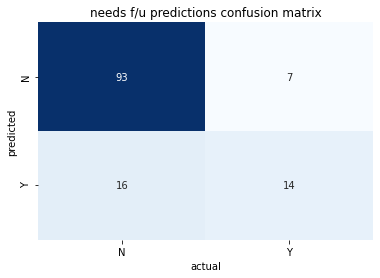

In [43]:
get_metrics(predictions, preds, targets)

In [44]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,thyroid baseline,652,NaN,0.905804,0.907692,0.814766,0.666667,0.736842,64
1,thyroid baseline,652,NaN,0.842980,0.838462,0.892273,0.550000,0.478261,64
2,thyroid baseline,652,NaN,0.801190,0.807692,0.783636,0.300000,0.352941,64
3,thyroid baseline,652,NaN,0.835404,0.838462,0.834000,0.600000,0.666667,64
4,thyroid baseline,652,NaN,0.785400,0.792308,0.836333,0.466667,0.560000,64
5,thyroid baseline,652,NaN,0.810601,0.815385,0.839333,0.533333,0.615385,64
6,label smoothing,652,"(0.7, 0.3)",0.811275,0.823077,0.785333,0.466667,0.666667,64


In [45]:
wandb.finish()



test performance for confidence cutoff of  0.55
# of samples removed: 6
% of samples removed: 4.62%
# of results remaining:  124
Metrics Report:
---------------
weighted f1:  0.8154611294932339
AUROC:        0.797459165154265
accuracy:     0.8306451612903226
precision:    [0.8490566  0.72222222]
recall:       [0.94736842 0.44827586]
sensitivity:  0.7222222222222222
specificity:  0.8490566037735849
PPV:          0.4482758620689655
NPV:          0.9473684210526315



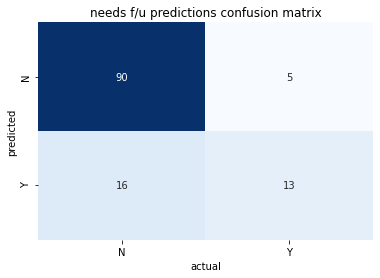



test performance for confidence cutoff of  0.6
# of samples removed: 13
% of samples removed: 10.00%
# of results remaining:  117
Metrics Report:
---------------
weighted f1:  0.8318452380952381
AUROC:        0.7950126796280642
accuracy:     0.8461538461538461
precision:    [0.86138614 0.75      ]
recall:       [0.95604396 0.46153846]
sensitivity:  0.75
specificity:  0.8613861386138614
PPV:          0.46153846153846156
NPV:          0.9560439560439561



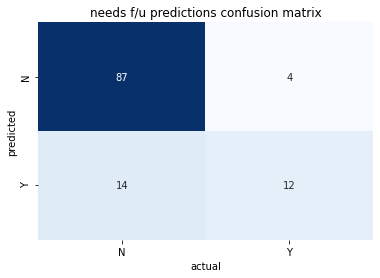



test performance for confidence cutoff of  0.65
# of samples removed: 17
% of samples removed: 13.08%
# of results remaining:  113
Metrics Report:
---------------
weighted f1:  0.8417356551527262
AUROC:        0.8103448275862069
accuracy:     0.8584070796460177
precision:    [0.85858586 0.85714286]
recall:       [0.97701149 0.46153846]
sensitivity:  0.8571428571428571
specificity:  0.8585858585858586
PPV:          0.46153846153846156
NPV:          0.9770114942528736



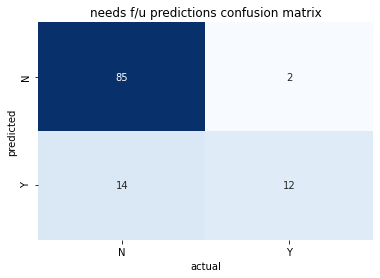



test performance for confidence cutoff of  0.7
# of samples removed: 31
% of samples removed: 23.85%
# of results remaining:  99
Metrics Report:
---------------
weighted f1:  0.8563865955170302
AUROC:        0.8398169336384439
accuracy:     0.8686868686868687
precision:    [0.87058824 0.85714286]
recall:       [0.97368421 0.52173913]
sensitivity:  0.8571428571428571
specificity:  0.8705882352941177
PPV:          0.5217391304347826
NPV:          0.9736842105263158



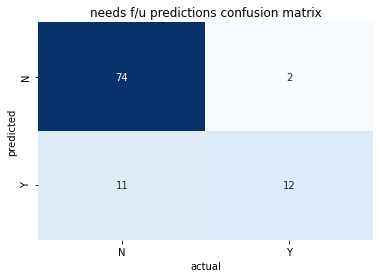



test performance for confidence cutoff of  0.75
# of samples removed: 36
% of samples removed: 27.69%
# of results remaining:  94
Metrics Report:
---------------
weighted f1:  0.8596563011456628
AUROC:        0.8297297297297298
accuracy:     0.8723404255319149
precision:    [0.87804878 0.83333333]
recall:       [0.97297297 0.5       ]
sensitivity:  0.8333333333333334
specificity:  0.8780487804878049
PPV:          0.5
NPV:          0.972972972972973



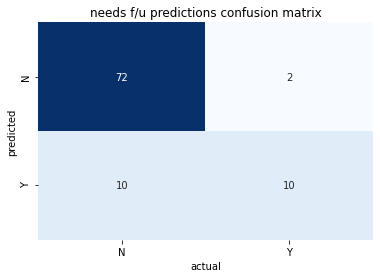



test performance for confidence cutoff of  0.8
# of samples removed: 44
% of samples removed: 33.85%
# of results remaining:  86
Metrics Report:
---------------
weighted f1:  0.8597865646783048
AUROC:        0.8455882352941176
accuracy:     0.872093023255814
precision:    [0.88       0.81818182]
recall:       [0.97058824 0.5       ]
sensitivity:  0.8181818181818182
specificity:  0.88
PPV:          0.5
NPV:          0.9705882352941176



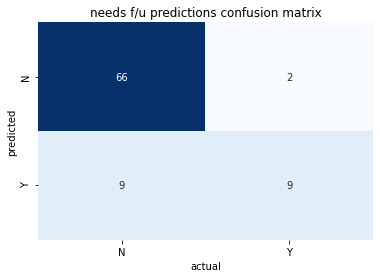



test performance for confidence cutoff of  0.85
# of samples removed: 63
% of samples removed: 48.46%
# of results remaining:  67
Metrics Report:
---------------
weighted f1:  0.8865192252603025
AUROC:        0.8867924528301887
accuracy:     0.8955223880597015
precision:    [0.89655172 0.88888889]
recall:       [0.98113208 0.57142857]
sensitivity:  0.8888888888888888
specificity:  0.896551724137931
PPV:          0.5714285714285714
NPV:          0.9811320754716981



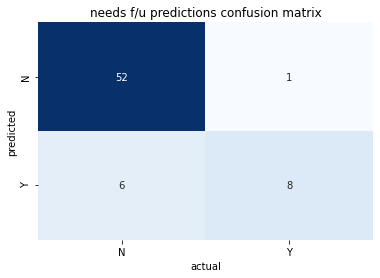



test performance for confidence cutoff of  0.9
# of samples removed: 94
% of samples removed: 72.31%
# of results remaining:  36
Metrics Report:
---------------
weighted f1:  0.9444444444444444
AUROC:        0.9465020576131687
accuracy:     0.9444444444444444
precision:    [0.96296296 0.88888889]
recall:       [0.96296296 0.88888889]
sensitivity:  0.8888888888888888
specificity:  0.9629629629629629
PPV:          0.8888888888888888
NPV:          0.9629629629629629



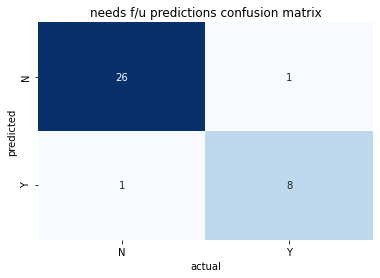

In [76]:
possible_cutoffs = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
for cutoff in possible_cutoffs:
    temp_results = [(item,np.argmax(item), targ) for item,targ in zip(preds, targets) if np.max((item[0],item[1])) >= cutoff]
    removed_samples = len(preds) - len(temp_results)
    print ()
    print ('\ntest performance for confidence cutoff of ',cutoff)
    print ('# of samples removed: {}'.format(removed_samples))
    print ('% of samples removed: {0:.2f}%'.format(100*removed_samples/len(preds)))
    print ('# of results remaining: ', len(temp_results))
    temp_probs = torch.vstack([i[0] for i in temp_results])
    temp_predictions = torch.vstack([i[1] for i in temp_results])
    temp_targets = torch.vstack([i[2] for i in temp_results])
    get_metrics(temp_predictions,temp_probs, temp_targets)

## third pass at classification

complex or not

In [13]:
with open(model_path + '/lm_vocab_big.pkl', 'rb') as f:
    lm_vocab = pickle.load(f)

In [33]:
desc = 'complexity training, seq len 512'
num_samples = len(data)
weights = None
batch_size = 32    #fast.ai default

In [34]:
dls_cls = TextDataLoaders.from_df(data, text_vocab=lm_vocab, text_col = 'Complete Result', label_col = 'complexity', seq_len = 512, bs = batch_size, num_workers = 0)

C:\Users\jasko\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [35]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, seq_len = 512, metrics=accuracy).to_fp16()

In [36]:
learn.load_encoder('C:\\Users\\jasko\\Desktop\\machine_learning\\thyroid_aspiration\\models/finetuned_enc_fwd');

In [37]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.557579,0.548906,0.839056,00:23


In [38]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.521557,0.546329,0.839056,00:27


In [39]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.533671,0.538475,0.839056,00:35


In [40]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.518600,0.540329,0.839056,00:43
1,0.519839,0.542735,0.839056,00:43


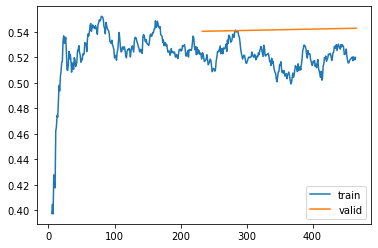

In [41]:
learn.recorder.plot_loss()

In [42]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

Metrics Report:
---------------
weighted f1:  0.7656261737471267
AUROC:        0.6060446255879565
accuracy:     0.8390557939914163
precision:    0.704014625430566
recall:       0.8390557939914163
Class: 0
Accuracy: 0/121

Class: 1
Accuracy: 1564/1564

Class: 2
Accuracy: 0/179



C:\Users\jasko\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


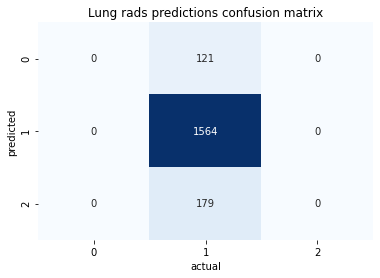

In [43]:
get_metrics_multi(preds, predictions, targets)

In [44]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,baseline,9323,NaN,0.974544,0.974964,0.9544127574471734,0.975150,0.974964,64
1,larger batch,9323,NaN,0.975863,0.976395,0.9544127574471734,0.975472,0.976395,64
2,more epochs,9323,NaN,0.983810,0.984263,0.9544127574471734,0.983923,0.984263,64
3,more epochs (3/5),9323,NaN,0.987229,0.987124,0.997327640877446,0.987416,0.987124,64
4,unstructured valid set,9323,NaN,0.978190,0.977500,can not calculate auroc,0.979587,0.977500,64
5,part_formatted valid set,9323,NaN,0.995994,0.996000,can not calculate auroc,0.996097,0.996000,64
6,backwards,9323,NaN,0.977716,0.978541,0.9406059492769087,0.976908,0.978541,64
7,ensembling combined,9323,NaN,0.988369,0.988915,0.9738505839541627,0.987901,0.988915,64
8,ensembling bwd,9323,NaN,0.986063,0.986581,0.973554565853024,0.985622,0.986581,64
9,ensembling fwd,9323,NaN,0.988358,0.988915,0.979112918218776,0.987872,0.988915,64


In [29]:
learn.export(model_path + '/complexity_baseline_fwd.pkl')

#### brute force complexity assessment

In [6]:
data.columns

Index(['Exam', 'Date', 'Recall/Rebook', 'Other Comment', 'Exam Result',
       'Complete Result', 'lr num', 'needs f/u', 'labels', 'complexity',
       'f/u in idoc', 'Recall/Rebook 2', 'Combined Recall/Rebook',
       'needed screening f/u in idoc', 'proper followup triggered',
       'maybe proper followup triggered', 'is_valid_unformatted',
       'is_valid_part_formatted', 'is_valid_formatted', 'is_valid'],
      dtype='object')

In [7]:
Counter(data.complexity)

Counter({'structured': 7855, 'problem/manual': 559, 'unstructured': 909})

In [11]:
def determine_complexity(s):
    # a little pre-processing
    s  = s.replace('BI-RADS', 'lung-rads')  # to deal with some typos I found
    s = s.replace('L-RADS', 'lung-rads')  # to deal with some typos I found
    s = s.lower()
    
    pattern = 'lung[- ]rads[\:]*[\s]*'
    if not re.search(pattern, s):
        return 'problem/manual'
    else:
        return 'other'

data['complexity analysis'] = data['Complete Result'].map(determine_complexity)

In [12]:
Counter(data['complexity analysis'])

Counter({'other': 8861, 'problem/manual': 462})

## fwd bwd ensembling

#### forward

In [73]:
desc = 'thyroid baseline'
num_samples = len(data)
weights = None
batch_size = 64    #fast.ai default

In [74]:
with open(model_path + '/lm_vocab.pkl', 'rb') as f:
    lm_vocab = pickle.load(f)

In [75]:
dls_cls = TextDataLoaders.from_df(ltd_data, text_col = 'Exam Result', label_col = 'target', seed = 42, text_vocab = lm_vocab, num_workers = 0)

C:\Users\jasko\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [76]:
wandb.init(project='thyroid asp', name = 'baseline');

In [77]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=accuracy, cbs=[WandbCallback(), SaveModelCallback(fname = 'thyroid')]).to_fp16()

In [78]:
learn.load_encoder(model_path + '/finetuned_enc_fwd');

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.14454397559165955)

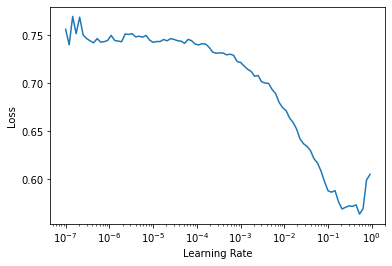

In [79]:
learn.lr_find()

In [80]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.735494,0.703933,0.523077,00:01
1,0.653137,0.548239,0.776923,00:01
2,0.591443,0.570084,0.815385,00:01


Better model found at epoch 0 with valid_loss value: 0.7039328217506409.
Better model found at epoch 1 with valid_loss value: 0.5482387542724609.


In [81]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.504840,0.563672,0.746154,00:01
1,0.482525,0.549951,0.792308,00:01
2,0.433926,0.576698,0.669231,00:01


Better model found at epoch 0 with valid_loss value: 0.5636721253395081.
Better model found at epoch 1 with valid_loss value: 0.549950897693634.


In [82]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.332696,0.811587,0.630769,00:02
1,0.334162,0.538020,0.715385,00:02
2,0.288639,0.539831,0.715385,00:02


Better model found at epoch 0 with valid_loss value: 0.8115865588188171.
Better model found at epoch 1 with valid_loss value: 0.5380204916000366.


In [83]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.225286,0.504662,0.715385,00:02
1,0.210732,0.503390,0.730769,00:02
2,0.192585,0.563584,0.738462,00:02
3,0.177575,0.538526,0.746154,00:02
4,0.169562,0.533817,0.746154,00:02


Better model found at epoch 0 with valid_loss value: 0.5046619176864624.
Better model found at epoch 1 with valid_loss value: 0.503390371799469.


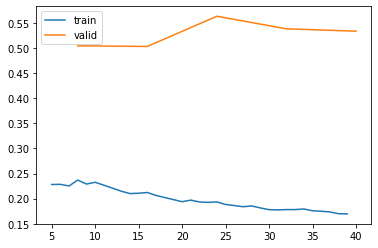

In [84]:
learn.recorder.plot_loss()

In [85]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis = 1)

In [49]:
stacked = torch.cat([preds, predictions.unsqueeze(-1), targets.unsqueeze(-1)], dim = 1)

fwd_results = pd.DataFrame(stacked)

In [50]:
fwd_results.to_csv(results_path + '/fwd_results.csv', index = False)

Metrics Report:
---------------
weighted f1:  0.7419846258908404
AUROC:        0.8069999999999999
accuracy:     0.7307692307692307
precision:    [0.85714286 0.43589744]
recall:       [0.78       0.56666667]
sensitivity:  0.4358974358974359
specificity:  0.8571428571428571
PPV:          0.5666666666666667
NPV:          0.78



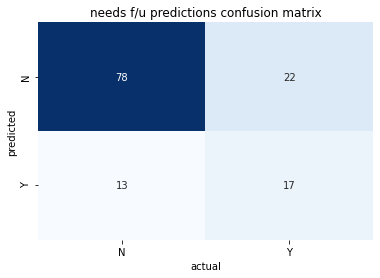

In [86]:
get_metrics(predictions, preds, targets)

In [52]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,thyroid baseline,652,NaN,0.905804,0.907692,0.814766,0.666667,0.736842,64
1,thyroid baseline,652,NaN,0.842980,0.838462,0.892273,0.550000,0.478261,64
2,thyroid baseline,652,NaN,0.801190,0.807692,0.783636,0.300000,0.352941,64
3,thyroid baseline,652,None,0.835404,0.838462,0.834000,0.600000,0.666667,64


In [53]:
learn.export(model_path + '/thyroid_baseline_fwd.pkl')

In [54]:
wandb.finish()

#### backward

In [55]:
wandb.init(project='thyroid asp', name = 'baseline_b');

In [56]:
dls_cls_bwd = TextDataLoaders.from_df(data, text_vocab=lm_vocab, text_col = 'Exam Result', label_col = 'target', seed = 42, bs = batch_size, num_workers = 0, is_backward = True)

C:\Users\jasko\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [57]:
learn = text_classifier_learner(dls_cls_bwd, AWD_LSTM, drop_mult=0.5, metrics=accuracy, cbs=[WandbCallback(), SaveModelCallback(fname = 'thyroid_b')]).to_fp16()

In [58]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.738561,0.701083,0.507692,00:01
1,0.646336,0.544099,0.746154,00:01
2,0.599025,0.533090,0.738462,00:01


Better model found at epoch 0 with valid_loss value: 0.7010829448699951.
Better model found at epoch 1 with valid_loss value: 0.5440988540649414.
Better model found at epoch 2 with valid_loss value: 0.5330900549888611.


In [59]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.498480,0.796757,0.553846,00:01
1,0.486419,0.487488,0.792308,00:01
2,0.447387,0.564748,0.661538,00:01


Better model found at epoch 0 with valid_loss value: 0.7967566847801208.
Better model found at epoch 1 with valid_loss value: 0.48748767375946045.


In [60]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.393526,0.525112,0.800000,00:02
1,0.352019,0.669246,0.723077,00:02
2,0.315842,0.490100,0.753846,00:02


Better model found at epoch 0 with valid_loss value: 0.525111973285675.
Better model found at epoch 2 with valid_loss value: 0.49009963870048523.


In [61]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.246246,0.449446,0.753846,00:03
1,0.233588,0.461169,0.815385,00:03
2,0.223696,0.449156,0.807692,00:02
3,0.212884,0.438807,0.807692,00:03
4,0.202425,0.438431,0.792308,00:03


Better model found at epoch 0 with valid_loss value: 0.449445903301239.
Better model found at epoch 2 with valid_loss value: 0.4491555392742157.
Better model found at epoch 3 with valid_loss value: 0.4388066232204437.
Better model found at epoch 4 with valid_loss value: 0.43843087553977966.


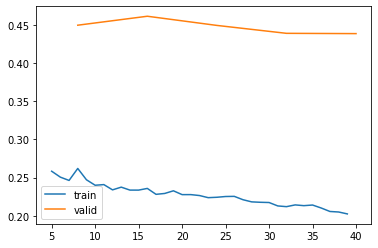

In [62]:
learn.recorder.plot_loss()

In [63]:
wandb.finish()

In [64]:
preds_bwd, targets_bwd = learn.get_preds()
predictions_bwd = np.argmax(preds_bwd, axis = 1)

In [65]:
stacked = torch.cat([preds_bwd, predictions_bwd.unsqueeze(-1), targets_bwd.unsqueeze(-1)], dim = 1)

bwd_results = pd.DataFrame(stacked)

In [66]:
bwd_results.to_csv(results_path + '/bwd_results.csv', index = False)

Metrics Report:
---------------
weighted f1:  0.7853999658877707
AUROC:        0.8363333333333334
accuracy:     0.7923076923076923
precision:    [0.84761905 0.56      ]
recall:       [0.89       0.46666667]
sensitivity:  0.56
specificity:  0.8476190476190476
PPV:          0.4666666666666667
NPV:          0.89



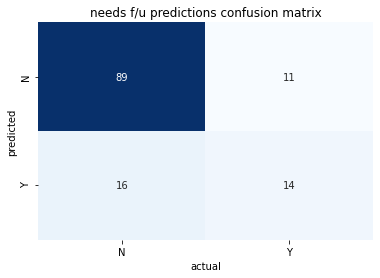

In [67]:
get_metrics(predictions_bwd, preds_bwd, targets_bwd)

Metrics Report:
---------------
weighted f1:  0.8106011635423401
AUROC:        0.8393333333333334
accuracy:     0.8153846153846154
precision:    [0.86538462 0.61538462]
recall:       [0.9        0.53333333]
sensitivity:  0.6153846153846154
specificity:  0.8653846153846154
PPV:          0.5333333333333333
NPV:          0.9



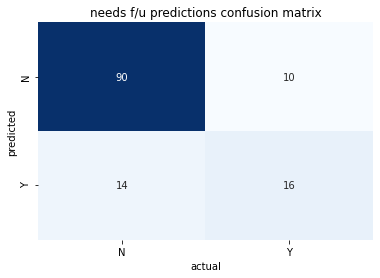

In [68]:
#ensembling
#desc = 'ensembling'
preds_e = (preds + preds_bwd)/2
predictions_e = np.argmax(preds_e, axis = 1)
get_metrics(predictions_e, preds_e,  targets_bwd)

In [72]:
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,thyroid baseline,652,NaN,0.905804,0.907692,0.814766,0.666667,0.736842,64
1,thyroid baseline,652,NaN,0.842980,0.838462,0.892273,0.550000,0.478261,64
2,thyroid baseline,652,NaN,0.801190,0.807692,0.783636,0.300000,0.352941,64
3,thyroid baseline,652,None,0.835404,0.838462,0.834000,0.600000,0.666667,64
4,thyroid baseline,652,None,0.785400,0.792308,0.836333,0.466667,0.560000,64
5,thyroid baseline,652,None,0.810601,0.815385,0.839333,0.533333,0.615385,64


In [70]:
results_df.to_csv('results lung rads.csv', index = False)

In [71]:
learn.export(model_path + '/lr_baseline_bwd.pkl')

RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:274] . unexpected pos 83109184 vs 83109072